# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [71]:
%pip install optuna==3.6.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time
import os
import pickle
import duckdb



In [73]:
base_path = os.path.expanduser(r'C:\Users\janic\OneDrive\Documentos\github\eyf\\')
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_con_clase.csv'
dataset_file_with_features = 'competencia_01_con_clase_y_features.csv'

ganancia_acierto = 780000
costo_estimulo = 20000



data = pd.read_csv(base_path + dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [74]:
# # --- Código base con lags ---
# data = data.drop(columns=['cprestamos_personales', 'mprestamos_personales'])
# data = data.sort_values(["numero_de_cliente", "foto_mes"]).reset_index(drop=True)

# cols_lag = [
#     "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen",
#     "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_dolares", "mcuentas_saldo",
#     "ctarjeta_debito_transacciones", "mautoservicio", "ctarjeta_visa_transacciones",
#     "mtarjeta_visa_consumo", "ctarjeta_master_transacciones", "mtarjeta_master_consumo", 
#     "mprestamos_prendarios", "mprestamos_hipotecarios",
#     "mplazo_fijo_dolares", "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares",
#     "minversion2", "mpayroll", "mpayroll2", "mcuenta_debitos_automaticos",
#     "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos",
#     "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos",
#     "mtarjeta_visa_descuentos", "mtarjeta_master_descuentos",
#     "mcomisiones_mantenimiento", "mcomisiones_otras",
#     "mforex_buy", "mforex_sell", "mtransferencias_recibidas", "mtransferencias_emitidas",
#     "mextraccion_autoservicio", "mcheques_depositados", "mcheques_emitidos",
#     "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados",
#     "chomebanking_transacciones", "ctrx_quarter", "cmobile_app_trx"
# ]

# new_data = {}

# for col in cols_lag:
#     grupo = data.groupby("numero_de_cliente")[col]
    
#     # --- Lags ---
#     lag1 = grupo.shift(1)
#     lag2 = grupo.shift(2)
#     new_data[f"nis_{col}_lag1"] = lag1
#     new_data[f"nis_{col}_lag2"] = lag2
#     new_data[f"nis_{col}_delta_lag1"] = data[col] - lag1
#     new_data[f"nis_{col}_delta_lag2"] = data[col] - lag2
    
#     # --- Máximos y mínimos históricos sin mirar el futuro ---
#     # Se hace shift(1) para que el valor actual no se incluya
#     rolling_max = grupo.shift(1).expanding().max()
#     rolling_min = grupo.shift(1).expanding().min()
#     new_data[f"nis_{col}_max_hist"] = rolling_max
#     new_data[f"nis_{col}_min_hist"] = rolling_min

# # --- Combinar con el dataset original ---
# new_cols = pd.DataFrame(new_data)
# data = pd.concat([data, new_cols], axis=1).copy()


In [75]:
# import duckdb
# import pandas as pd

# # --- Preprocesamiento básico ---
# data = data.drop(columns=['cprestamos_personales', 'mprestamos_personales'], errors='ignore')
# data = data.sort_values(["numero_de_cliente", "foto_mes"]).reset_index(drop=True)

# # --- Conexión en memoria ---
# con = duckdb.connect(database=':memory:')
# con.register("data", data)

# cols_lag = [
#     "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen",
#     "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_dolares", "mcuentas_saldo",
#     "ctarjeta_debito_transacciones", "mautoservicio", "ctarjeta_visa_transacciones",
#     "mtarjeta_visa_consumo", "ctarjeta_master_transacciones", "mtarjeta_master_consumo", 
#     "mprestamos_prendarios", "mprestamos_hipotecarios",
#     "mplazo_fijo_dolares", "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares",
#     "minversion2", "mpayroll", "mpayroll2", "mcuenta_debitos_automaticos",
#     "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos",
#     "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos",
#     "mtarjeta_visa_descuentos", "mtarjeta_master_descuentos",
#     "mcomisiones_mantenimiento", "mcomisiones_otras",
#     "mforex_buy", "mforex_sell", "mtransferencias_recibidas", "mtransferencias_emitidas",
#     "mextraccion_autoservicio", "mcheques_depositados", "mcheques_emitidos",
#     "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados",
#     "chomebanking_transacciones", "ctrx_quarter", "cmobile_app_trx"
# ]

# # --- 1️⃣ Capa intermedia: calcular solo los lags y deltas ---
# lag_sql_parts = []
# for col in cols_lag:
#     lag_sql_parts.append(f"""
#         LAG({col}, 1) OVER w AS nis_{col}_lag1,
#         LAG({col}, 2) OVER w AS nis_{col}_lag2,
#         {col} - LAG({col}, 1) OVER w AS nis_{col}_delta_lag1,
#         {col} - LAG({col}, 2) OVER w AS nis_{col}_delta_lag2
#     """)

# sql_lags = f"""
# CREATE TEMP TABLE lag_data AS
# SELECT
#     *,
#     {', '.join(lag_sql_parts)}
# FROM data
# WINDOW w AS (PARTITION BY numero_de_cliente ORDER BY foto_mes)
# """

# con.execute(sql_lags)

# # --- 2️⃣ Segunda capa: calcular los max y min históricos (sin mirar el futuro) ---
# maxmin_sql_parts = []
# for col in cols_lag:
#     maxmin_sql_parts.append(f"""
#         MAX(nis_{col}_lag1) OVER w2 AS nis_{col}_max_hist,
#         MIN(nis_{col}_lag1) OVER w2 AS nis_{col}_min_hist
#     """)

# sql_final = f"""
# SELECT
#     *,
#     {', '.join(maxmin_sql_parts)}
# FROM lag_data
# WINDOW w2 AS (PARTITION BY numero_de_cliente ORDER BY foto_mes ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
# ORDER BY numero_de_cliente, foto_mes
# """

# data = con.execute(sql_final).df()
# con.close()


In [76]:
def generar_features(data):
    
    data = data.drop(columns=['cprestamos_personales', 'mprestamos_personales'], errors='ignore')
    data = data.sort_values(["numero_de_cliente", "foto_mes"]).reset_index(drop=True)
    
    con = duckdb.connect(database=':memory:')
    con.register("data", data)
    
    cols_lag = [
        "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen",
        "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_dolares", "mcuentas_saldo",
        "ctarjeta_debito_transacciones", "mautoservicio", "ctarjeta_visa_transacciones",
        "mtarjeta_visa_consumo", "ctarjeta_master_transacciones", "mtarjeta_master_consumo", 
        "mprestamos_prendarios", "mprestamos_hipotecarios",
        "mplazo_fijo_dolares", "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares",
        "minversion2", "mpayroll", "mpayroll2", "mcuenta_debitos_automaticos",
        "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos",
        "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos",
        "mtarjeta_visa_descuentos", "mtarjeta_master_descuentos",
        "mcomisiones_mantenimiento", "mcomisiones_otras",
        "mforex_buy", "mforex_sell", "mtransferencias_recibidas", "mtransferencias_emitidas",
        "mextraccion_autoservicio", "mcheques_depositados", "mcheques_emitidos",
        "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados",
        "chomebanking_transacciones", "ctrx_quarter", "cmobile_app_trx"
    ]
    
    lag_sql_parts = []
    for col in cols_lag:
        lag_sql_parts.append(f"""
            LAG({col}, 1) OVER w AS nis_{col}_lag1,
            LAG({col}, 2) OVER w AS nis_{col}_lag2,
            {col} - LAG({col}, 1) OVER w AS nis_{col}_delta_lag1,
            {col} - LAG({col}, 2) OVER w AS nis_{col}_delta_lag2
        """)
    
    sql_lags = f"""
    CREATE TEMP TABLE lag_data AS
    SELECT
        *,
        {', '.join(lag_sql_parts)}
    FROM data
    WINDOW w AS (PARTITION BY numero_de_cliente ORDER BY foto_mes)
    """
    
    con.execute(sql_lags)
    
    # --- 2️⃣ Máximos y mínimos históricos ---
    maxmin_sql_parts = []
    for col in cols_lag:
        maxmin_sql_parts.append(f"""
            MAX(nis_{col}_lag1) OVER w2 AS nis_{col}_max_hist,
            MIN(nis_{col}_lag1) OVER w2 AS nis_{col}_min_hist
        """)
    
    sql_final = f"""
    COPY (
        SELECT
            *,
            {', '.join(maxmin_sql_parts)}
        FROM lag_data
        WINDOW w2 AS (
            PARTITION BY numero_de_cliente
            ORDER BY foto_mes
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        )
        ORDER BY numero_de_cliente, foto_mes 
    ) TO '{dataset_file_with_features}' (HEADER, DELIMITER ',');
    """
    
    con.execute(sql_final)
    con.close()
    
    print(f"✅ Archivo guardado como {dataset_file_with_features}")

#generar_features(data)

In [77]:

data = pd.read_csv(base_path + dataset_file_with_features)

In [ ]:
# mes_train_competencia_2 = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
#  202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
#  202101]

# mes_train_competencia_1= [202101,202102,202103]

# mes_test_competencia_1 = 202102

# mes_test_competencia_2 = 202104


mes_train= [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101]
mes_test= 202104


semillas = [17,19,23,29,31]


In [79]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_binaria2 = test_data['clase_binaria2']

w_test = test_data['clase_peso']

In [80]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}


In [81]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm_ultimo_intento.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-11-11 20:00:43,378] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [82]:
#study.optimize(objective, n_trials=5) 

In [83]:

num_leaves = study.best_trial.params['num_leaves']
learning_rate = study.best_trial.params['learning_rate']
min_data_in_leaf = study.best_trial.params['min_data_in_leaf']
feature_fraction = study.best_trial.params['feature_fraction']
bagging_fraction = study.best_trial.params['bagging_fraction']

# num_leaves = 96
# learning_rate = 0.10786251291535232
# min_data_in_leaf = 844
# feature_fraction = 0.817823789674196
# bagging_fraction = 0.9701924741567449

#los que uso:
"""
num_leaves= 75
learning_rate= 0.09050296119713902
min_data_in_leaf= 406
feature_fraction= 0.420671602155407
bagging_fraction= 0.1153395502686529
"""

print("num_leaves:",num_leaves)
print("learning_rate:", learning_rate)
print("min_data_in_leaf:", min_data_in_leaf)
print("feature_fraction:", feature_fraction)
print("bagging_fraction:", bagging_fraction)


num_leaves: 75
learning_rate: 0.09050296119713902
min_data_in_leaf: 406
feature_fraction: 0.420671602155407
bagging_fraction: 0.1153395502686529


In [84]:
best_iter = study.best_trial.user_attrs["best_iter"]

print(f"Mejor cantidad de árboles para el mejor model {best_iter}")

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'min_data_in_leaf': min_data_in_leaf,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 100


In [85]:
model.save_model(modelos_path + 'lgb_first.txt')
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')
# filename_rf_1000 = modelos_path + 'exp_206_random_forest_model_1000.sav'
# model_rf_1000 = pickle.load(open(filename_rf_1000, 'rb'))
# y_pred_rf = model_rf_1000.predict_proba(Xif)
# y_pred_rf = y_pred_rf[:,1] # adaptamos la salida para que sea homogénea con el LGBM

y_pred_lgm = model.predict(X_test)

In [86]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia LGBM 1:", ganancia_prob(y_pred_lgm, y_test_binaria1))
print("Ganancia LGBM 2:", ganancia_prob(y_pred_lgm, y_test_binaria2))



Ganancia LGBM 1: 325080000.0
Ganancia LGBM 2: 980280000.0


In [87]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Parámetros
threshold = 0.025
ganancia_acierto = 780000
costo_estimulo = 20000

# Asegurarnos que X_test.index está alineado con data
if not set(X_test.index).issubset(set(data.index)):
    raise ValueError("Los índices de X_test no están todos en data.index. Asegurate de usar el mismo orden/filtrado.")

# Etiquetas reales (texto) y versión binaria (1 = BAJA+2, 0 = BAJA+1 o CONTINUA)
y_true_labels = data.loc[X_test.index, 'clase_ternaria'].astype(str)
y_test_binaria = (y_true_labels == "BAJA+2").astype(int)

# Predicciones (probabilidades -> 0/1 por umbral)
y_pred_prob = y_pred_lgm  # asumimos que esto son probabilidades alineadas con X_test
y_pred_binaria = (y_pred_prob >= threshold).astype(int)

# Conteos básicos
n_total = len(y_test_binaria)
n_pred1 = int(y_pred_binaria.sum())
n_pred0 = n_total - n_pred1

# Matriz de confusión
labels = [0, 1]
cm = confusion_matrix(y_test_binaria, y_pred_binaria, labels=labels)
TN, FP, FN, TP = cm.ravel()

# Aciertos y fallos
aciertos = (y_pred_binaria == y_test_binaria).sum()
fallos = n_total - aciertos

# --- 1️⃣ Ganancia REAL ---
ganancia_real = TP * ganancia_acierto - FP * costo_estimulo

# --- 2️⃣ Ganancia IDEAL ---
total_bajas2 = int(y_test_binaria.sum())
ganancia_ideal = total_bajas2 * ganancia_acierto

# --- 3️⃣ Ganancia PREDICHA (esperada según probabilidades) ---
mask_contactar = y_pred_prob >= threshold
ganancia_predicha = (
    (y_pred_prob[mask_contactar] * ganancia_acierto) - 
    (1 - y_pred_prob[mask_contactar]) * costo_estimulo
).sum()

# --- Ganancia máxima posible si contactaras el mismo número ---
ganancia_mejor_posible_dado_n = (
    n_pred1 * ganancia_acierto if n_pred1 <= total_bajas2
    else total_bajas2 * ganancia_acierto - (n_pred1 - total_bajas2) * costo_estimulo
)

# --- Mostrar resultados ---
print(f"===== Evaluación del modelo (umbral = {threshold:.3f}) =====")
print(f"Total evaluados: {n_total}")
print(f"Predijo 1 (contactar): {n_pred1}")
print(f"Predijo 0 (no contactar): {n_pred0}\n")

print("Matriz de confusión (real vs predicho):")
print(cm)
print(f"TN={TN}, FP={FP}, FN={FN}, TP={TP}\n")

print(f"Aciertos totales: {aciertos}")
print(f"Fallos totales: {fallos}\n")

print(f"💰 Ganancia REAL: {ganancia_real:,.0f}")
print(f"💎 Ganancia IDEAL: {ganancia_ideal:,.0f}")
print(f"📊 Ganancia PREDICHA (esperada): {ganancia_predicha:,.0f}")
print(f"🧭 Ganancia MÁXIMA posible con mismo n: {ganancia_mejor_posible_dado_n:,.0f}\n")

if ganancia_mejor_posible_dado_n != 0:
    print(f"Eficiencia respecto a mejor con mismo n: {ganancia_real / ganancia_mejor_posible_dado_n:.2%}")
if ganancia_ideal != 0:
    print(f"Eficiencia respecto a ideal (contactando todos BAJA+2): {ganancia_real / ganancia_ideal:.2%}")
if ganancia_predicha != 0:
    print(f"Desvío entre ganancia real y predicha: {max(ganancia_real - ganancia_predicha, ganancia_predicha-ganancia_real):,.0f}")


===== Evaluación del modelo (umbral = 0.025) =====
Total evaluados: 163418
Predijo 1 (contactar): 14386
Predijo 0 (no contactar): 149032

Matriz de confusión (real vs predicho):
[[148667  13620]
 [   365    766]]
TN=148667, FP=13620, FN=365, TP=766

Aciertos totales: 149433
Fallos totales: 13985

💰 Ganancia REAL: 325,080,000
💎 Ganancia IDEAL: 882,180,000
📊 Ganancia PREDICHA (esperada): 871,913,654
🧭 Ganancia MÁXIMA posible con mismo n: 617,080,000

Eficiencia respecto a mejor con mismo n: 52.68%
Eficiencia respecto a ideal (contactando todos BAJA+2): 36.85%
Desvío entre ganancia real y predicha: 546,833,654


In [88]:
ganancia = np.where(y_test_binaria2 == 1, ganancia_acierto, 0) - np.where(y_test_binaria2 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


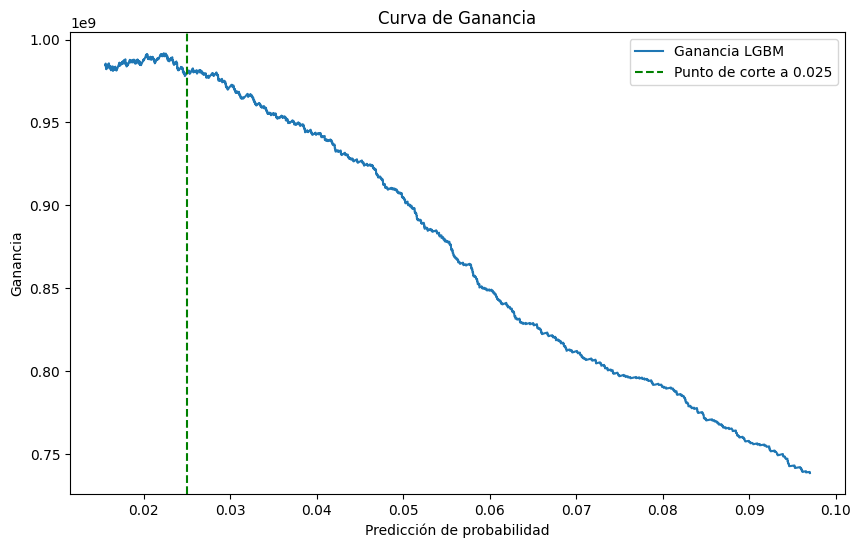

In [89]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


In [90]:
idx_max = np.argmax(ganancia_cum[piso_envios:techo_envios])
prob_max = y_pred_lgm[piso_envios:techo_envios][idx_max]
ganancia_max = ganancia_cum[piso_envios:techo_envios][idx_max]

print(f"Máxima ganancia: {ganancia_max:.2f} en probabilidad {prob_max:.4f}")


Máxima ganancia: 991800000.00 en probabilidad 0.0223


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

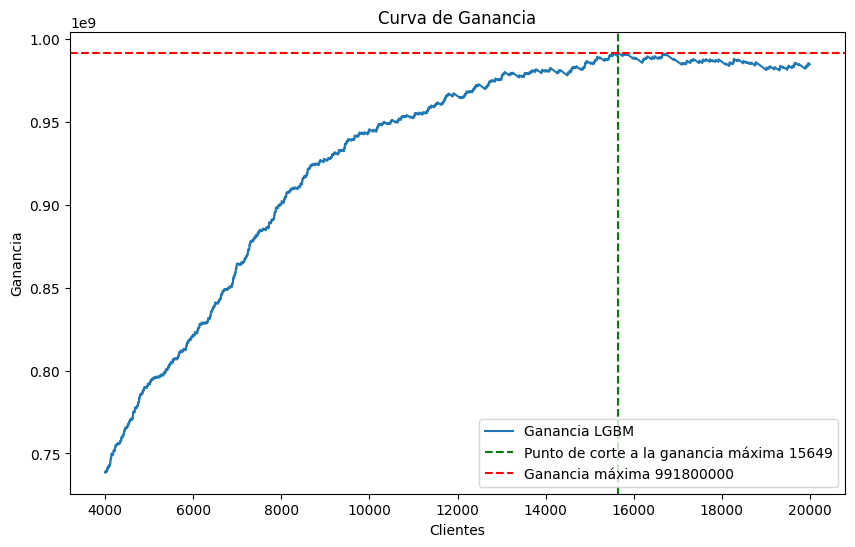

In [91]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


In [92]:
# train_data = data[data['foto_mes'].isin([202102,202101,202103, 202104])]
# y_train_binaria2 = train_data['clase_binaria2']
# w_train = train_data['clase_peso']
# X_train_con_abril = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)


# train_data_con_abril = lgb.Dataset(X_train_con_abril,
#                           label=y_train_binaria2,
#                           weight=w_train)

# model = lgb.train(params,
#                   train_data_con_abril,
#                   num_boost_round=best_iter)


# # Load data for predecir
# data_predecir = data[data['foto_mes'] == 202106].copy()

# # Preprocess the data (same as training and testing data)
# X_predecir = data_predecir.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
# # Removed imputation: X_predecir_imputed = imp_mean.transform(X_predecir)

# # Make predictions using the trained LightGBM model (from cell bwyUriQksZAM)
# # Using X_predecir directly, assuming no missing values or LightGBM is configured to handle them
# y_pred_predecir = model.predict(X_predecir)

# # --- Display summary statistics of predictions ---
# print("\nSummary statistics of predicted probabilities:")
# print(pd.Series(y_pred_predecir).describe())
# # -------------------------------------------------


# # Apply a fixed threshold of 0.025
# fixed_threshold = 0.0233
# data_predecir['predicted'] = np.where(y_pred_predecir >= fixed_threshold, 1, 0)

# # Create the output DataFrame with numero_de_cliente and predicted columns
# output_df = data_predecir[['numero_de_cliente', 'predicted']]

# # Count the number of predicted positives and print it
# num_predicted_positives = output_df['predicted'].sum()
# print(f"\nNumber of predicted positives in predecir with threshold {fixed_threshold}: {num_predicted_positives}")

# # Save the predictions to a CSV file
# output_path = base_path + 'predicciones_predecir_01.csv'
# output_df.to_csv(output_path, index=False)

# print(f"Predictions saved to: {output_path}")


In [93]:
seeds = [
    1234, 2025, 9876, 777, 5555, 345, 67, 89, 90,
    42, 101, 314, 2718
]

fixed_threshold = 0.026
meses_entrenamiento = mes_train + [mes_test]
mes_prediccion = 202106

# --- Preparar data de entrenamiento ---
train_data = data[data['foto_mes'].isin(meses_entrenamiento)].copy()
y_train = train_data['clase_binaria2']
w_train = train_data['clase_peso']
X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'], axis=1)

# --- Preparar data de predicción ---
data_predecir = data[data['foto_mes'] == mes_prediccion].copy()
X_predecir = data_predecir.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'], axis=1)

# --- Dataset de LightGBM ---
train_lgb = lgb.Dataset(X_train, label=y_train, weight=w_train)

# --- Predicciones por seed ---
predicciones_por_seed = []

for seed in seeds:
    print(f"\n🌱 Entrenando modelo con seed = {seed}")

    params_seed = params.copy()
    params_seed['seed'] = seed
    params_seed['feature_fraction_seed'] = seed
    params_seed['bagging_seed'] = seed

    model = lgb.train(
        params_seed,
        train_lgb,
        num_boost_round=best_iter,
    )

    y_pred = model.predict(X_predecir)
    predicciones_por_seed.append(y_pred)

# --- Promediar las probabilidades ---
preds_promedio = np.mean(predicciones_por_seed, axis=0)

# --- Aplicar punto de corte al promedio ---
data_predecir['predicted'] = np.where(preds_promedio >= fixed_threshold, 1, 0)

# --- Crear DataFrame final ---
output_df = data_predecir[['numero_de_cliente', 'predicted']]
num_predicted_positives = output_df['predicted'].sum()

# --- Guardar CSV ---
output_path = base_path + 'predicciones_predecir_promedio_seeds.csv'
output_df.to_csv(output_path, index=False)

# --- Mostrar resultados ---
print(f"\n✅ Archivo final guardado en: {output_path}")
print(f"👉 Clientes predichos como 1 (usando promedio y threshold {fixed_threshold}): {num_predicted_positives:,}")

# --- (Opcional) Mostrar estadísticas del promedio de probabilidades ---
print("\n📊 Estadísticas del promedio de probabilidades:")
print(pd.Series(preds_promedio).describe())





🌱 Entrenando modelo con seed = 1234

🌱 Entrenando modelo con seed = 2025

🌱 Entrenando modelo con seed = 9876

🌱 Entrenando modelo con seed = 777

🌱 Entrenando modelo con seed = 5555

🌱 Entrenando modelo con seed = 345

🌱 Entrenando modelo con seed = 67

🌱 Entrenando modelo con seed = 89

🌱 Entrenando modelo con seed = 90

🌱 Entrenando modelo con seed = 42

🌱 Entrenando modelo con seed = 101

🌱 Entrenando modelo con seed = 314

🌱 Entrenando modelo con seed = 2718

✅ Archivo final guardado en: C:\Users\janic\OneDrive\Documentos\github\eyf\\predicciones_predecir_promedio_seeds.csv
👉 Clientes predichos como 1 (usando promedio y threshold 0.026): 13,859

📊 Estadísticas del promedio de probabilidades:
count    164313.000000
mean          0.011048
std           0.041429
min           0.000033
25%           0.000362
50%           0.001114
75%           0.004933
max           0.914813
dtype: float64


In [97]:
import lightgbm as lgb
import numpy as np
import pandas as pd

# --- Configuración ---
mes_prediccion = 202106
seeds = [
    7, 42, 89, 123, 345, 678, 910, 2025, 3141, 4321,
    5555, 6060, 7077, 8080, 9876, 11111, 12345, 24680, 27182, 30007
]

# --- Datos ---
train_data = data[data['foto_mes'].isin(mes_train)].copy()
y_train = train_data['clase_binaria2']
w_train = train_data['clase_peso']
X_train = train_data.drop(['clase_ternaria','clase_peso','clase_binaria1','clase_binaria2'], axis=1)

data_pred = data[data['foto_mes'] == mes_prediccion].copy()
X_pred = data_pred.drop(['clase_ternaria','clase_peso','clase_binaria1','clase_binaria2'], axis=1)

print(f"🧮 Tamaño entrenamiento: {len(X_train)} filas")
print(f"🧮 Tamaño predicción: {len(X_pred)} filas")

# --- Tomar los 5 mejores trials de Optuna ---
valid_trials = [t for t in study.trials if t.value is not None]
top_trials = sorted(valid_trials, key=lambda t: t.value)[:3]

print("\n📊 Mejores 5 trials seleccionados para el ensamble:")
for i, trial in enumerate(top_trials, start=1):
    print(f"\n🔹 Trial {i} | valor objetivo: {trial.value:.6f}")
    for k, v in trial.params.items():
        print(f"  {k}: {v}")

fixed_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'bagging_freq': 1,
    'verbose': -1
}

ensemble_preds = []
model_scores = []

for i, trial in enumerate(top_trials, start=1):
    print(f"\n🌱 Entrenando modelo {i} del ensamble completo...")
    params = fixed_params.copy()
    params.update(trial.params)

    preds_seed = np.zeros(len(X_pred))
    loglosses = []

    for seed in seeds:
        params['seed'] = seed

        model = lgb.train(
            params,
            lgb.Dataset(X_train, label=y_train, weight=w_train),
            num_boost_round=500
        )

        # Predicción para el mes de test
        pred = model.predict(X_pred)
        preds_seed += pred / len(seeds)

        # Logloss simple sobre entrenamiento (solo para ponderar)
        p_train = model.predict(X_train)
        logloss = -np.mean(y_train * np.log(p_train + 1e-15) + (1 - y_train) * np.log(1 - p_train + 1e-15))
        loglosses.append(logloss)

    # Promedio de logloss de las semillas
    mean_logloss = np.mean(loglosses)
    model_scores.append(mean_logloss)
    ensemble_preds.append(preds_seed)
    print(f"✅ Modelo {i} logloss (promedio semillas): {mean_logloss:.5f}")

# --- Combinar modelos ponderando por 1/logloss ---
weights = np.array([1/s for s in model_scores])
weights /= weights.sum()

final_preds = np.zeros(len(X_pred))
for pred, w in zip(ensemble_preds, weights):
    final_preds += pred * w

# --- Buscar threshold óptimo ---
thresholds = np.linspace(0.01, 0.05, 50)
best_gain = -np.inf
best_threshold = 0.026  # valor inicial por si no mejora

for t in thresholds:
    predicted = (final_preds >= t).astype(int)
    gain = predicted.sum() * ganancia_acierto - predicted.sum() * costo_estimulo
    if gain > best_gain:
        best_gain = gain
        best_threshold = t

# --- Aplicar threshold ---
data_pred['predicted'] = (final_preds >= best_threshold).astype(int)

# --- Guardar CSV ---
output_df = data_pred[['numero_de_cliente','predicted']]
output_path = base_path + f'predicciones_ensembles_optuna_top5_{mes_prediccion}.csv'
output_df.to_csv(output_path, index=False)

print(f"\n✅ Archivo final guardado: {output_path}")
print(f"Threshold óptimo: {best_threshold:.5f}")
print(f"Clientes predichos como 1: {output_df['predicted'].sum()}")


🧮 Tamaño entrenamiento: 486791 filas
🧮 Tamaño predicción: 164313 filas

📊 Mejores 5 trials seleccionados para el ensamble:

🔹 Trial 1 | valor objetivo: 712180000.000000
  num_leaves: 8
  learning_rate: 0.27596896127132226
  min_data_in_leaf: 33
  feature_fraction: 0.8752140362313454
  bagging_fraction: 0.47730376406524433

🔹 Trial 2 | valor objetivo: 739160000.000000
  num_leaves: 21
  learning_rate: 0.2871659829948413
  min_data_in_leaf: 761
  feature_fraction: 0.18725796929724398
  bagging_fraction: 0.9185961940283688

🔹 Trial 3 | valor objetivo: 752440000.000000
  num_leaves: 40
  learning_rate: 0.23685113327933427
  min_data_in_leaf: 192
  feature_fraction: 0.8004296891363291
  bagging_fraction: 0.37440378058395996

🌱 Entrenando modelo 1 del ensamble completo...
✅ Modelo 1 logloss (promedio semillas): 0.12406

🌱 Entrenando modelo 2 del ensamble completo...
✅ Modelo 2 logloss (promedio semillas): 0.01443

🌱 Entrenando modelo 3 del ensamble completo...
✅ Modelo 3 logloss (promedio se

C:\Users\janic\AppData\Local\Temp\ipykernel_11724\4177543997.py:92: RuntimeWarning: overflow encountered in scalar multiply
  gain = predicted.sum() * ganancia_acierto - predicted.sum() * costo_estimulo
C:\Users\janic\AppData\Local\Temp\ipykernel_11724\4177543997.py:92: RuntimeWarning: overflow encountered in scalar subtract
  gain = predicted.sum() * ganancia_acierto - predicted.sum() * costo_estimulo



✅ Archivo final guardado: C:\Users\janic\OneDrive\Documentos\github\eyf\\predicciones_ensembles_optuna_top5_202106.csv
Threshold óptimo: 0.03286
Clientes predichos como 1: 8388


In [ ]:
def calcular_ganancia(y_pred_prob, threshold, ganancia_acierto, costo_estimulo):
    """
    Calcula la ganancia total esperada dado un vector de probabilidades
    y un threshold de decisión.
    """
    predicted_positives = y_pred_prob >= threshold

    ganancia_total = np.sum(predicted_positives * (ganancia_acierto * y_pred_prob - costo_estimulo))
    
    return ganancia_total

threshold = 0.026
ganancia = calcular_ganancia(preds_promedio, threshold, ganancia_acierto, costo_estimulo)
print(f"💰 Ganancia esperada total para threshold {threshold}: ${ganancia:,.0f}")


thresholds = np.arange(0.01, 0.091, 0.001) 
ganancias_por_threshold = []

for t in thresholds:
    g = calcular_ganancia(preds_promedio, t, ganancia_acierto, costo_estimulo)
    ganancias_por_threshold.append((t, g))

ganancias_df = pd.DataFrame(ganancias_por_threshold, columns=['threshold', 'ganancia'])
print("\n📊 Ganancia por distintos thresholds:")
print(ganancias_df)


max_idx = ganancias_df['ganancia'].idxmax()
mejor_threshold = ganancias_df.loc[max_idx, 'threshold']
max_ganancia = ganancias_df.loc[max_idx, 'ganancia']

print(f"🏆 Ganancia máxima: ${max_ganancia:,.0f} alcanzada con threshold = {mejor_threshold:.4f}")


NameError: name 'preds_promedio' is not defined

In [ ]:
predicciones = pd.read_csv(base_path + 'predicciones_ensembles_optuna_top3_202106.csv')

# --- 2️⃣ Definir el mes a evaluar ---
mes_eval = 202106

# --- 3️⃣ Filtrar solo los datos reales de ese mes ---
data_eval = data[data['foto_mes'] == mes_eval][['numero_de_cliente', 'clase_ternaria']]

# --- 4️⃣ Unir predicciones con los datos reales de ese mes ---
merged = predicciones.merge(
    data_eval,
    on='numero_de_cliente',
    how='left'
)

# --- 5️⃣ Definir qué se considera acierto ---
def es_acierto(row):
    if row['predicted'] == 1 and row['clase_ternaria'] == 'BAJA+2':
        return True
    if row['predicted'] == 0 and row['clase_ternaria'] in ['CONTINUA', 'BAJA+1']:
        return True
    return False

merged['acierto'] = merged.apply(es_acierto, axis=1)

# --- 6️⃣ Métricas básicas ---
aciertos = merged['acierto'].sum()
errores = len(merged) - aciertos
precision = aciertos / len(merged)

print(f"Aciertos: {aciertos}")
print(f"Errores: {errores}")
print(f"Precisión: {precision:.2%}")
print(f"Cantidad total: {aciertos+errores}")
print(f"Cantidad filas totales de {mes_eval} a predecir: {(data['foto_mes'] == mes_eval).sum()}")


# --- (Opcional) Ver algunos errores ---
print("\n🔍 Ejemplos de errores:")
print(merged[~merged['acierto']].head())
